## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
!pip install nltk
!pip install swifter
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install seaborn
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=be3ef3f8a800de377a28e831018268b0fee1801b1db3f31e8c1664199426fb9d
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 98.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [71]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [6]:
# Opening JSON file
f = "complaints-2021-05-14_08_16.json"

# returns JSON object as
# a dictionary
with open(f, 'r') as file:
    data = json.load(file)

df = pd.json_normalize(data)

## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
#Assign new column names
oldcols = list(df.columns)

newcols = [item.strip("_") for item in oldcols]
newcols = [item.replace("source.","") for item in newcols]

df.columns = newcols
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [10]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: x.strip()).replace('', np.nan)
df = df.rename(columns={'complaint_what_happened': 'complaints'})

In [11]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=["complaints"])
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text

df['complaints'] = df['complaints'].apply(clean_data)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is and i appreciate it if...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my card in and was told by the agen...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent ...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a ticket i came across...,Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it in...,Funds not handled or disbursed as instructed,Consent provided


In [13]:
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
#Write your function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

df['lemmatized'] = df['complaints'].apply(lemmatization)

In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean =df[['complaints','lemmatized']]

In [16]:
df_clean

,complaints,lemmatized
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...


In [17]:
#Write your function to extract the POS tags

def pos_tag(sentence):
    nn_words = []
    doc = nlp(sentence)

    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)

    nn_words_str = " ".join(nn_words)
    return nn_words_str

df_clean["lemmatized_POS"] =  df_clean['lemmatized'].apply(pos_tag)  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


/tmp/ipython-input-17-2422987163.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized,lemmatized_POS
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr credit card chase freedom problem ba...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




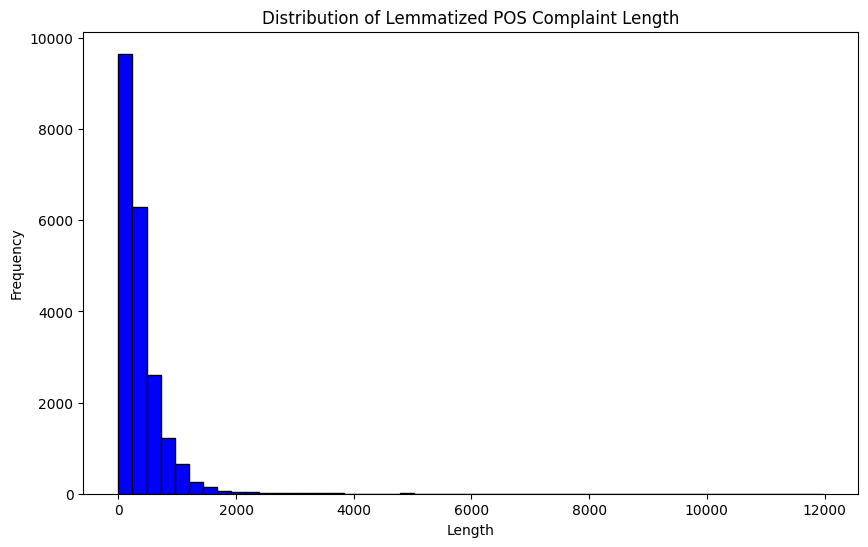

In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10, 6))
lenarray = [len(d) for d in df_clean.lemmatized_POS]
plt.hist(lenarray, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Lemmatized POS Complaint Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

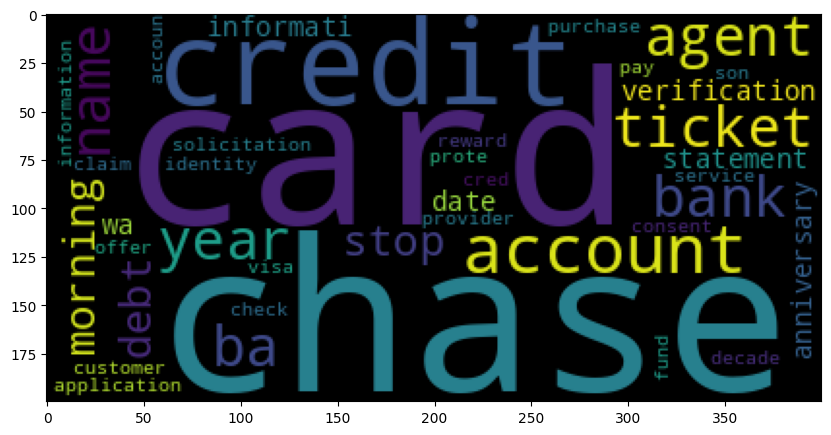

In [24]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['lemmatized_POS']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.show()

In [25]:
#Removing -PRON- from the text corpus
df_clean = df_clean.rename(columns={'lemmatized_POS': 'complaint_POS_removed'})
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [27]:
#Print the top 10 words in the unigram frequency
unigram = get_top_n_words(df_clean['Complaint_clean'], 1,10)
for word, freq in unigram:
    print(word, freq)
px.bar(x=[word for word, freq in unigram], y=[freq for word, freq in unigram], title='Top 10 Unigrams')

chase 62192
account 47952
credit 32808
card 30491
bank 21795
payment 21368
time 16313
day 13317
charge 12133
money 11998


In [28]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram = get_top_n_words(df_clean['Complaint_clean'], 2,30)
bigram

[('credit card', np.int64(12934)),
 ('credit report', np.int64(3892)),
 ('chase bank', np.int64(3847)),
 ('account chase', np.int64(3754)),
 ('chase account', np.int64(3543)),
 ('chase credit', np.int64(3416)),
 ('customer service', np.int64(3086)),
 ('account account', np.int64(2706)),
 ('checking account', np.int64(2659)),
 ('bank account', np.int64(2584)),
 ('debit card', np.int64(2055)),
 ('card chase', np.int64(2030)),
 ('chase card', np.int64(1935)),
 ('card account', np.int64(1763)),
 ('credit score', np.int64(1725)),
 ('phone call', np.int64(1653)),
 ('account credit', np.int64(1615)),
 ('payment payment', np.int64(1589)),
 ('money account', np.int64(1458)),
 ('chase chase', np.int64(1440)),
 ('account bank', np.int64(1373)),
 ('chase customer', np.int64(1369)),
 ('letter chase', np.int64(1342)),
 ('interest rate', np.int64(1312)),
 ('credit bureau', np.int64(1300)),
 ('business day', np.int64(1260)),
 ('phone number', np.int64(1256)),
 ('payment chase', np.int64(1255)),
 ('acc

In [29]:
#Print the top 10 words in the bigram frequency
px.bar(x=[word for word, freq in bigram[0:9]], y=[freq for word, freq in bigram[0:9]], title='Top 10 Bigrams')

In [30]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigram = get_top_n_words(df_clean['Complaint_clean'], 3,30)
trigram

[('chase credit card', np.int64(2281)),
 ('credit card account', np.int64(1114)),
 ('credit card company', np.int64(999)),
 ('credit card chase', np.int64(890)),
 ('chase customer service', np.int64(631)),
 ('inquiry credit report', np.int64(558)),
 ('credit card credit', np.int64(521)),
 ('chase bank account', np.int64(467)),
 ('account credit card', np.int64(461)),
 ('card credit card', np.int64(433)),
 ('account chase account', np.int64(396)),
 ('charge credit card', np.int64(380)),
 ('credit reporting agency', np.int64(378)),
 ('credit report credit', np.int64(377)),
 ('customer service representative', np.int64(352)),
 ('account credit report', np.int64(345)),
 ('credit reporting act', np.int64(343)),
 ('credit card payment', np.int64(320)),
 ('checking account chase', np.int64(302)),
 ('chase account chase', np.int64(294)),
 ('account chase bank', np.int64(277)),
 ('bank credit card', np.int64(272)),
 ('credit card balance', np.int64(271)),
 ('credit report chase', np.int64(270))

In [31]:
#Print the top 10 words in the trigram frequency
px.bar(x=[word for word, freq in trigram[0:9]], y=[freq for word, freq in trigram[0:9]], title='Top 10 Trigrams')

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [32]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [33]:
#All masked texts has been removed
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [39]:
#Write your code here to initialise the TfidfVectorizer
tfidf=TfidfVectorizer(max_df=0.98,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [41]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [42]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [44]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

5850

In [45]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index} with tf-idf score')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0 with tf-idf score
['business', 'fee', 'claim', 'number', 'transaction', 'checking', 'deposit', 'branch', 'day', 'fund', 'chase', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1 with tf-idf score
['customer', 'company', 'balance', 'time', 'fee', 'merchant', 'fraud', 'service', 'transaction', 'purchase', 'dispute', 'credit', 'chase', 'charge', 'card']


THE TOP 15 WORDS FOR TOPIC #2 with tf-idf score
['car', 'error', 'year', 'account', 'chase', 'date', 'credit', 'time', 'auto', 'day', 'statement', 'month', 'fee', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3 with tf-idf score
['limit', 'theft', 'application', 'identity', 'reporting', 'information', 'company', 'debt', 'bureau', 'score', 'account', 'card', 'inquiry', 'report', 'credit']


THE TOP 15 WORDS FOR TOPIC #4 with tf-idf score
['information', 'sale', 'house', 'foreclosure', 'document', 'rate', 'time', 'letter', 'year', 'property', 'modification', 'home', 'chase', 'mortgage

In [46]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(dtm)
topic_values.argmax(axis=1)

array([4, 1, 3, ..., 1, 2, 2])

In [47]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_values.argmax(axis=1)
#write your code to assign topics to each rows.

In [48]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,4
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,1
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,3
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0


In [49]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
17,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restricted my...,chase account debit card branch customer servi...,chase account debit card branch customer servi...,0
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0
27,i opened an account with chase bank on and use...,i opened an account with chase bank on and use...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
24,mishandling of this account by chase auto and,mishandling of this account by chase auto and,account auto,account auto,0
35,i opened the saving account for the bonus i wa...,i opened the saving account for the bonus i wa...,account bonus bonus auto transfer notice trans...,account bonus bonus auto transfer notice trans...,0
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,1
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,1
45,i made a purchase with on in the amount of i w...,i made a purchase with on in the amount of i w...,purchase amount transaction dispute case bank ...,purchase amount transaction dispute case bank ...,1
40,a sofa love seat table and chairs and was nev...,a sofa love seat table and chair and wa never ...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [50]:
#Create the dictionary of Topic names and Topics

Topic_names = {   0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/tmp/ipython-input-50-3492565602.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgage/Loan
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,Credit card or prepaid card
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,Theft/Dispute Reporting
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Bank Account services
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Theft/Dispute Reporting
17,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restricted my...,chase account debit card branch customer servi...,chase account debit card branch customer servi...,Bank Account services
20,during the summer months i eperience a decline...,during the summer month i eperience a decline ...,summer month decline income employment month p...,summer month decline income employment month p...,Others
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,Credit card or prepaid card
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,Theft/Dispute Reporting


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [52]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgage/Loan
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,Credit card or prepaid card
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,Theft/Dispute Reporting
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Bank Account services
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Theft/Dispute Reporting
17,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restricted my...,chase account debit card branch customer servi...,chase account debit card branch customer servi...,Bank Account services
20,during the summer months i eperience a decline...,during the summer month i eperience a decline ...,summer month decline income employment month p...,summer month decline income employment month p...,Others
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,Credit card or prepaid card
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,Theft/Dispute Reporting


In [53]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaints','Topic']]

In [54]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it if...,Mortgage/Loan
2,i upgraded my card in and was told by the agen...,Credit card or prepaid card
10,chase card was reported on however fraudulent ...,Theft/Dispute Reporting
11,on while trying to book a ticket i came across...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it in...,Bank Account services
15,can you please remove inquiry,Theft/Dispute Reporting
17,with out notice j p morgan chase restricted my...,Bank Account services
20,during the summer months i eperience a decline...,Others
21,on i made a payment to an online retailer usin...,Credit card or prepaid card
23,i have a chase credit card which is incorrectl...,Theft/Dispute Reporting


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [57]:

#Write your code to get the Vector count
count_vect=CountVectorizer()
X_train_vect=count_vect.fit_transform(training_data['complaints'])
tfidf_transformer=TfidfTransformer()
X_train_tf=tfidf_transformer.fit_transform(X_train_vect)
#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [60]:
# Write your code here to build any 3 models and evaluate them using the required metrics
train_X, test_X, train_y, test_y = train_test_split(X_train_tf, training_data['Topic'], test_size=0.4, random_state=40)

In [61]:
# Function to evaluate model
# function to evaluate the model and display the results
def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    print('Accuracy: ', accuracy_score(y_test,y_pred))
    print('Precision: ', precision_score(y_test,y_pred,average='weighted'))
    print('Recall: ', recall_score(y_test,y_pred,average='weighted'))
    print('F1 Score: ', f1_score(y_test,y_pred,average='weighted'))
#    print('ROC AUC Score: ', roc_auc_score(y_test,y_pred,average='weighted',multi_class='ovr'))
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    disp.plot()


# function to grid search the best parameters for the model
def run_model(model,param_grid):
    cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid={},cv=cv,scoring='f1_weighted',verbose=1,n_jobs=-1)
    grid.fit(train_X,train_y)
    return grid.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training results
Accuracy:  0.9333333333333333
Precision:  0.9466666666666667
Recall:  0.9333333333333333
F1 Score:  0.9259259259259259
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       1.00      1.00      1.00         4
Credit card or prepaid card       0.80      1.00      0.89         4
              Mortgage/Loan       1.00      1.00      1.00         3
                     Others       1.00      0.50      0.67         2
    Theft/Dispute Reporting       1.00      1.00      1.00         2

                   accuracy                           0.93        15
                  macro avg       0.96      0.90      0.91        15
               weighted avg       0.95      0.93      0.93        15

Test results
Accuracy:  0.2
Precision:  0.0625
Recall:  0.2
F1 Score:  0.08888888888888888
Classification Report:                               precision    

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=3.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: Undef

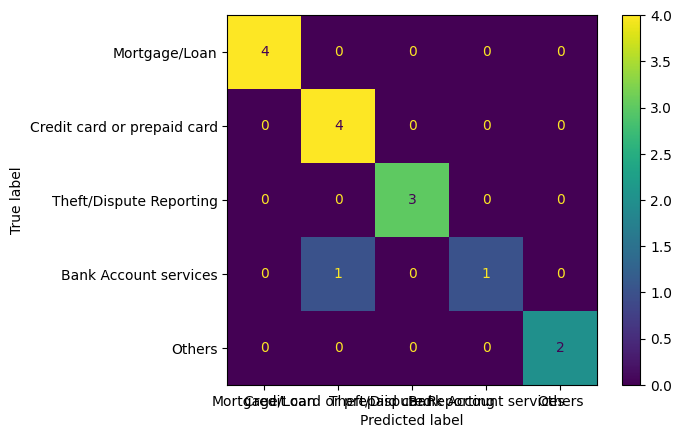

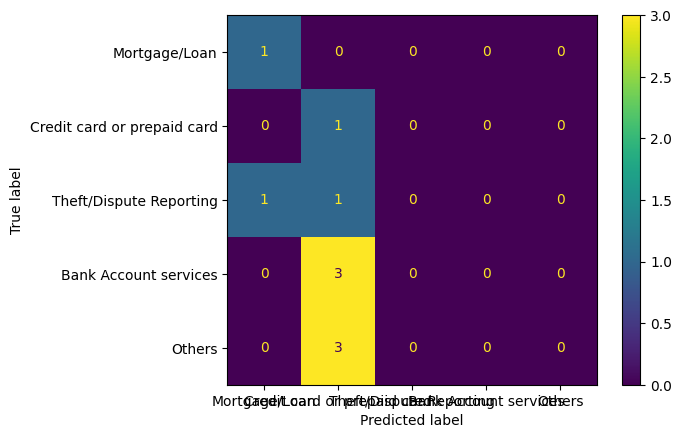

In [72]:
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500, 1000],
    'class_weight': [None, 'balanced']
}
model=run_model(LogisticRegression(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       1.00      1.00      1.00         4
Credit card or prepaid card       1.00      1.00      1.00         4
              Mortgage/Loan       1.00      1.00      1.00         3
                     Others       1.00      1.00      1.00         2
    Theft/Dispute Reporting       1.00      1.00      1.00         2

                   accuracy                           1.00        15
                  macro avg       1.00      1.00      1.00        15
               weighted avg       1.00      1.00      1.00        15

Test results
Accuracy:  0.2
Precision:  0.2
Recall:  0.2
F1 Score:  0.2
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       1.00      1.00   

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=3.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: Undef

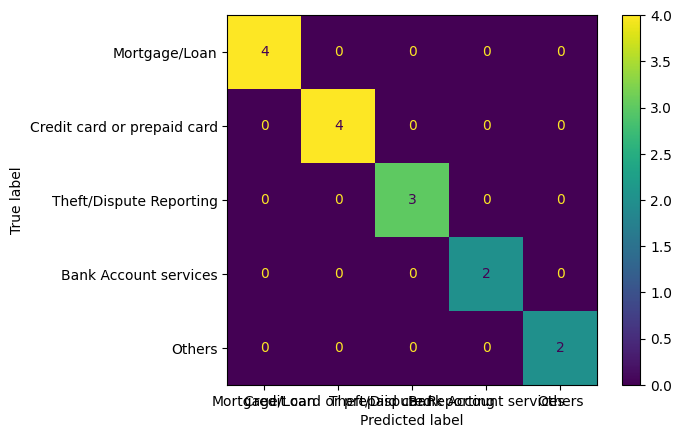

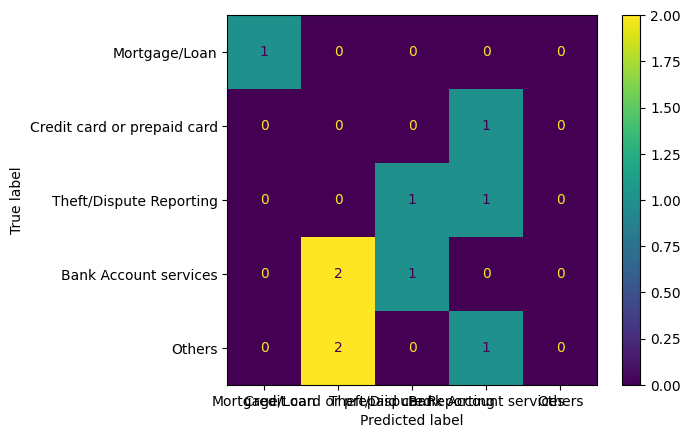

In [73]:
#running and evaluating the Decision Tree model
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}
model=run_model(DecisionTreeClassifier(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=3.



Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       1.00      1.00      1.00         4
Credit card or prepaid card       1.00      1.00      1.00         4
              Mortgage/Loan       1.00      1.00      1.00         3
                     Others       1.00      1.00      1.00         2
    Theft/Dispute Reporting       1.00      1.00      1.00         2

                   accuracy                           1.00        15
                  macro avg       1.00      1.00      1.00        15
               weighted avg       1.00      1.00      1.00        15

Test results
Accuracy:  0.3
Precision:  0.35
Recall:  0.3
F1 Score:  0.22999999999999998
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       0.25      1.00      0.40         1
Credit card or prepaid c

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



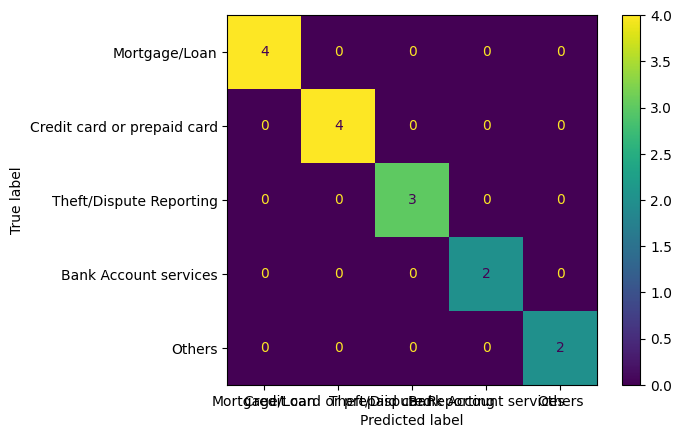

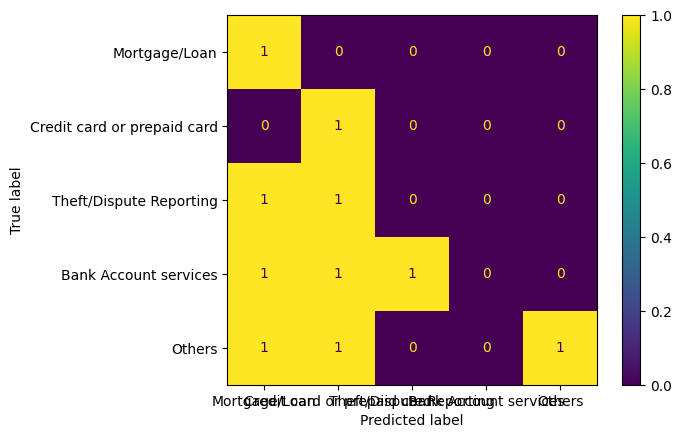

In [74]:
params = {
    'n_estimators': [10, 50, 100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
model=run_model(RandomForestClassifier(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training results
Accuracy:  0.8
Precision:  0.7244444444444444
Recall:  0.8
F1 Score:  0.7392592592592594
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       0.80      1.00      0.89         4
Credit card or prepaid card       0.67      1.00      0.80         4
              Mortgage/Loan       1.00      1.00      1.00         3
                     Others       0.00      0.00      0.00         2
    Theft/Dispute Reporting       1.00      0.50      0.67         2

                   accuracy                           0.80        15
                  macro avg       0.69      0.70      0.67        15
               weighted avg       0.72      0.80      0.74        15

Test results
Accuracy:  0.2
Precision:  0.0625
Recall:  0.2
F1 Score:  0.08888888888888888
Classification Report:                               precision    recall  f1-score   support

  

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=3.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: Undef

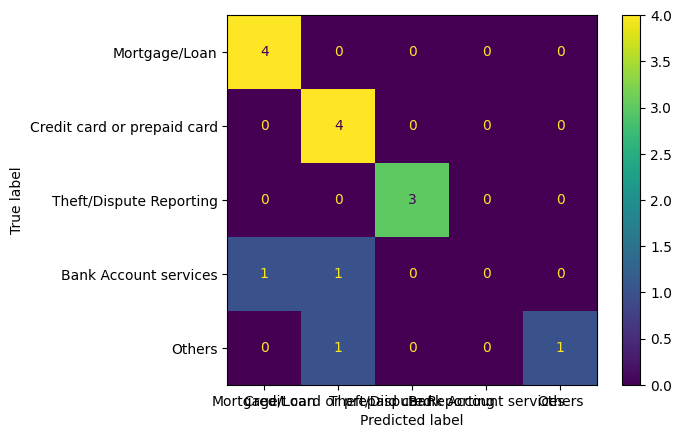

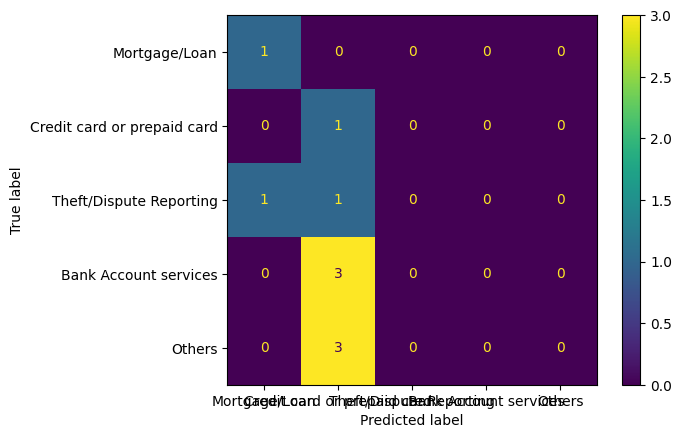

In [75]:
#running and evaluating the Gaussian Naive Bayes model
params = {
    'alpha': [0.1, 0.5, 1, 2, 5],
    'fit_prior': [True, False]
}
model=run_model(MultinomialNB(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')